# Исследование успешности игр интернет-магазина "Стримчик"
В нашем распоряжении данные о продажах игр, оценки пользователей и экспертов, жанры и платформы до 2016 года. На их основании нам необходимо выявить факторы, определяющие успешность той или иной компьтерной игры. Полученные результаты анализа могут быть использованы для планирования кампании на 2017 год, а также на основании выявленных принципов могут быть построены дальнейшие прогнозы.
## Описание данных
Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

### Шаг 1. Открытие файла с данными и изучение общей информации

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except FileNotFoundError:
    data = pd.read_csv('games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


По общей информации датафрейма выявлено:
1) Наличие пропусков в таких столбцах, как Year_of_Release, Critic_Score, User_Score и Rating

2) Не соответствие типа данных в столбце User_Score, Critic_Score и Year_of_Release

3) Использование верхнего и нижнего регистра в названии столбцов

Для дальнейшего анализа проведем предобработку данных

### Шаг 2. Предобработка данных

In [6]:
#заменим названия столбцов (приведем к нижнему регистру)
data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

In [7]:
#преобразуем данные в нужный тип столбца year_of_release
data['year_of_release'] = data['year_of_release'].fillna(0).astype('int') 
#год не может быть не целым числом, а пропуски заполнили условно 0, т.к. важно сохранить данные с рейтингами и продажами

In [8]:
#для преобразования в нужный тип столбец critic_score необходимо обработать пропуски
data['critic_score'].unique()
#поскольку кол-во пропусков существенно, а 0 отсутствует вкачестве значения, заменим пропуски на 0
data['critic_score'] = data['critic_score'].fillna(0).astype('int')

In [9]:
#для преобразования в нужный тип столбец user_score необходимо обработать пропуски
data['user_score'].unique()
data[data['user_score'] == 'tbd']['user_score'].count()

2424

In [10]:
#выявлено существенное кол-во значений 'tbd', которая может означать to be determind (русс. будет определено), происхождение данного значения определить затруднительно, т.о. заменить его на '-1', т.к. 0 присутствует вкачестве оценки
data.loc[data['user_score'] == 'tbd', 'user_score'] = '-1'

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '-1', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [12]:
#заменим оставшиеся пропуски также на -1 и преобразуем тип данных на float
data['user_score'] = data['user_score'].fillna(-1).astype('float') 

In [13]:
#проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  int64  
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


In [14]:
#существенное кол-во пропусков осталось в столбце rating = 6766, есть вероятность, что не все 
#игры подлежать рейтингования в рамках рассматриваемой системы оценки, т.о. обозначим отсутствие рейтинга как 'no rating'

data['rating'].unique()
data['rating'].isna().sum()

data['rating'] = data['rating'].fillna('no rating')


In [15]:
#посчитаем суммарные продажи в регионах и запишем их в новый столбец
data['total_sales'] = data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']

In [16]:
#проверка
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,-1.0,no rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,-1.0,no rating,31.38


In [17]:
#проверка на наличие дубликатов
data.duplicated().sum()

0

### Шаг 3. Проводим исследовательский анализ данных

In [18]:
#проанализиурем, сколько игр выпускалось в разные года
data['year_of_release'].value_counts()
#пик выпуска игр пришолся на период 2006-2011 гг. 

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
0        269
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

Text(0, 0.5, 'games')

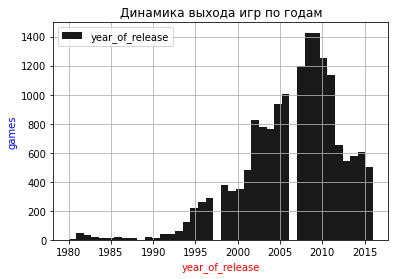

In [19]:
#для большей наглядности построим гистограмму без учета 0

ax = data.plot(y = 'year_of_release', kind = 'hist', bins = 40, grid = True, range = (1980, 2016), color = 'black', alpha = 0.9)
plt.title('Динамика выхода игр по годам');
ax.set_xlabel('year_of_release', color = 'red')
ax.set_ylabel('games', color = 'blue')

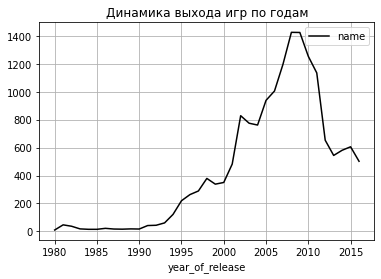

In [20]:
data_year = data.query('year_of_release != 0')
data_year.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(grid=True, style='-', color = 'black');
plt.title('Динамика выхода игр по годам');

### Вывод
По полученному графику видно, что выпуск существенного объема игр приходится на период 2006-2011гг., что может быть следствием развития технологий и увеличения финансирования данной отрасли. Первые игры выпускались еще в 80х, но объем выпуска незначительным. А в 2010х наблюдается спад релиза, вероятно, из-за перенасыщения рынка.

In [21]:
#проанализируем, как менялись продажи по платформам на примере платформ с макс. объемами продаж
#определим платформы с макс. продажами
data_pivot = data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum')
display(data_pivot.sort_values(by='total_sales', ascending = False).head())
#наибольшее кол-во продаж наблюдается на платформе PlayStation2

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


Text(0, 0.5, 'total_sales')

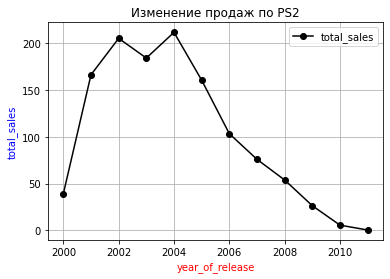

In [23]:
#построим по каждой график изменения продаж по годам
ps_2 = data.query('platform == "PS2" & year_of_release!= 0')
ab = ps_2.pivot_table(index= 'year_of_release', 
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', color = 'black');
plt.title('Изменение продаж по PS2');
ab.set_xlabel('year_of_release', color = 'red')
ab.set_ylabel('total_sales', color = 'blue')

Text(0, 0.5, 'total_sales')

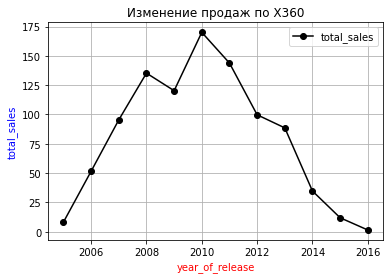

In [24]:
x_360 = data.query('platform == "X360" & year_of_release!= 0')
ac = x_360.pivot_table(index= 'year_of_release', 
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', color = 'black');
plt.title('Изменение продаж по X360');
ac.set_xlabel('year_of_release', color = 'red')
ac.set_ylabel('total_sales', color = 'blue')

Text(0, 0.5, 'total_sales')

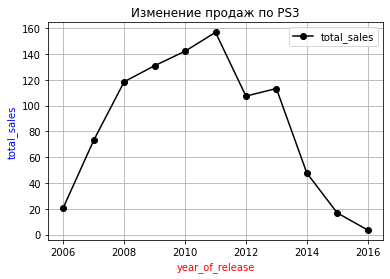

In [25]:
ps_3 = data.query('platform == "PS3" & year_of_release!= 0')
ad = ps_3.pivot_table(index= 'year_of_release', 
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', color = 'black');
plt.title('Изменение продаж по PS3');
ad.set_xlabel('year_of_release', color = 'red')
ad.set_ylabel('total_sales', color = 'blue')

Text(0, 0.5, 'total_sales')

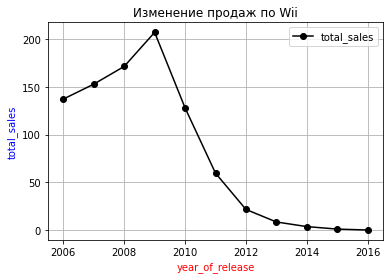

In [26]:
wii= data.query('platform == "Wii" & year_of_release!= 0')
ae = wii.pivot_table(index= 'year_of_release', 
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', color = 'black');
plt.title('Изменение продаж по Wii');
ae.set_xlabel('year_of_release', color = 'red')
ae.set_ylabel('total_sales', color = 'blue')

Text(0, 0.5, 'total_sales')

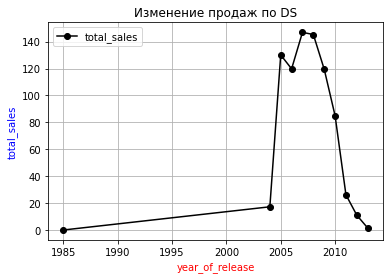

In [27]:
ds= data.query('platform == "DS" & year_of_release!= 0')
ag = ds.pivot_table(index= 'year_of_release', 
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', color = 'black');
plt.title('Изменение продаж по DS');
ag.set_xlabel('year_of_release', color = 'red')
ag.set_ylabel('total_sales', color = 'blue')

2600


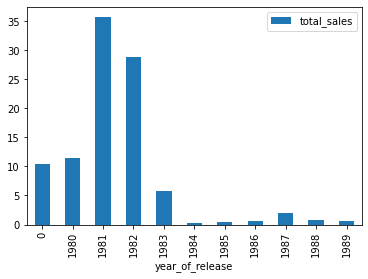

3DO


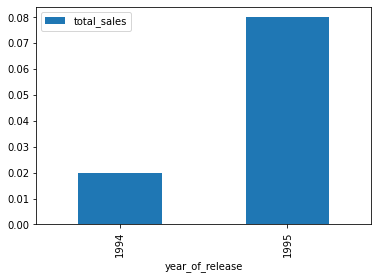

3DS


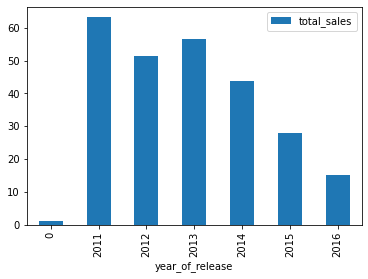

DC


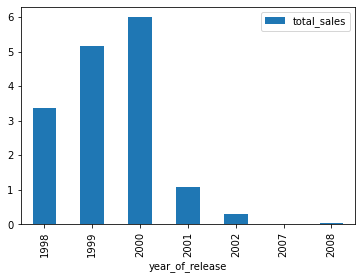

DS


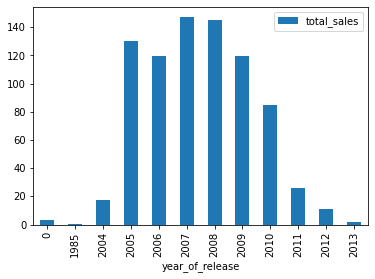

GB


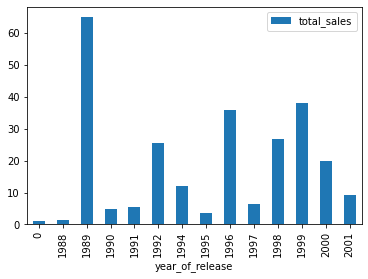

GBA


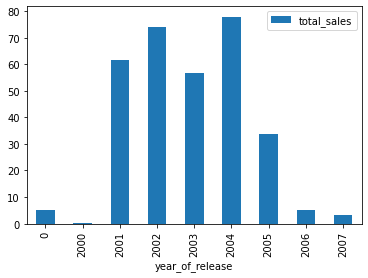

GC


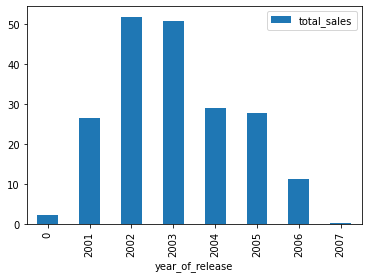

GEN


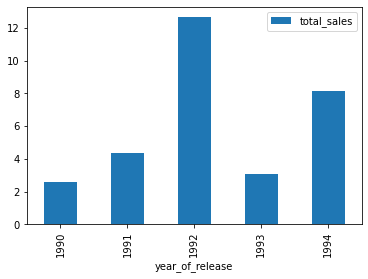

GG


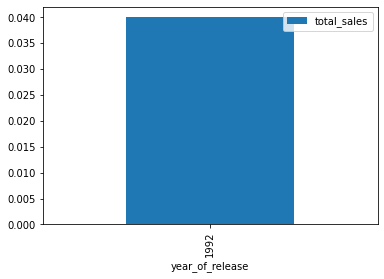

N64


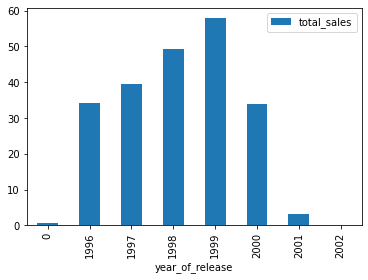

NES


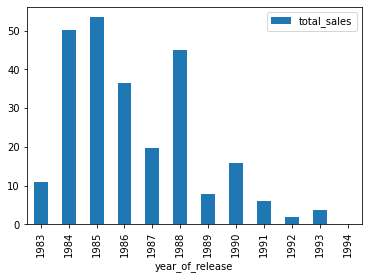

NG


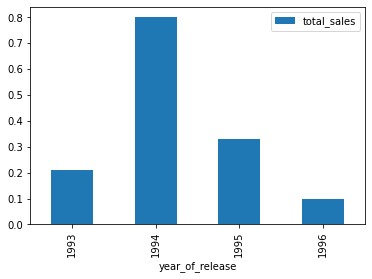

PC


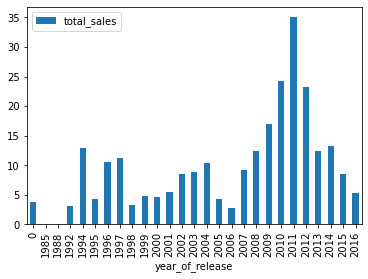

PCFX


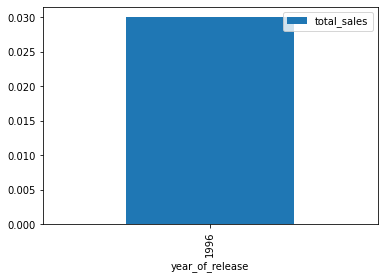

PS


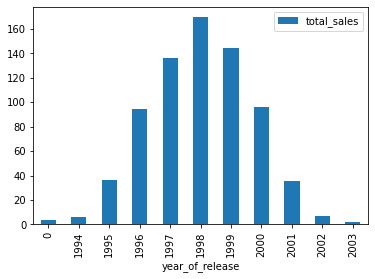

PS2


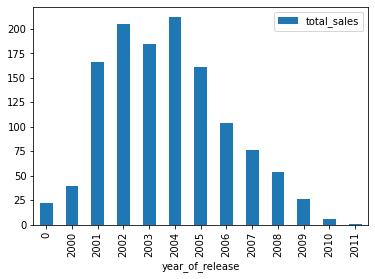

PS3


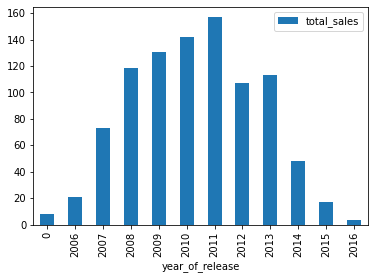

PS4


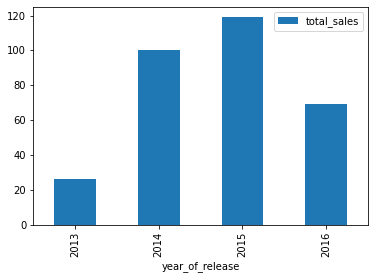

PSP


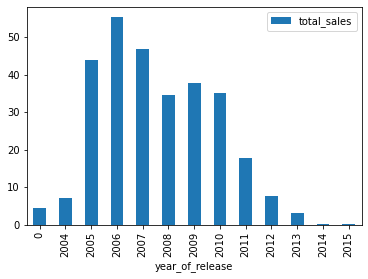

PSV


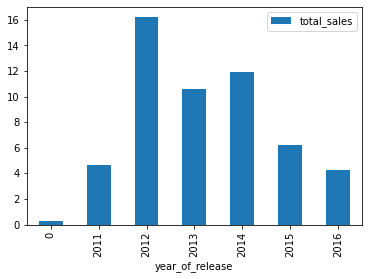

SAT


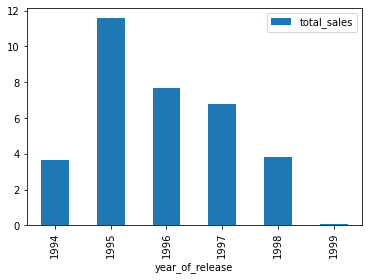

SCD


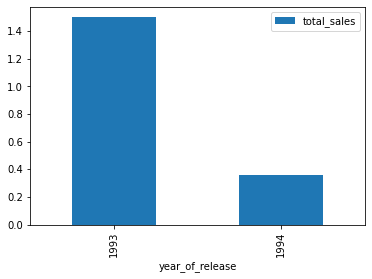

SNES


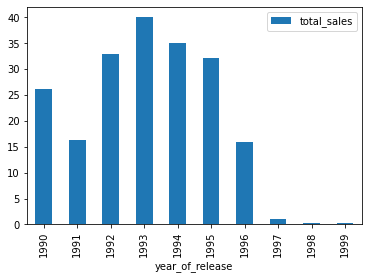

TG16


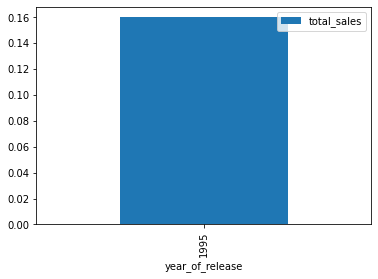

WS


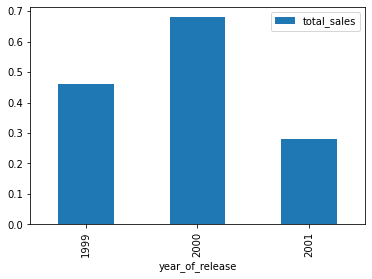

Wii


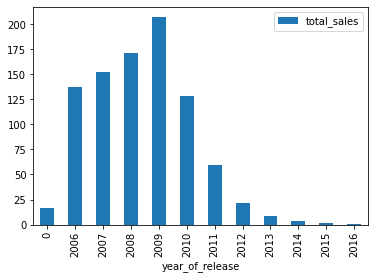

WiiU


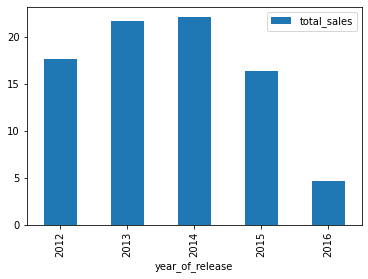

X360


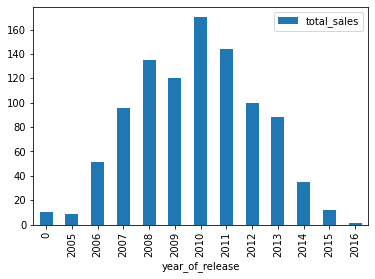

XB


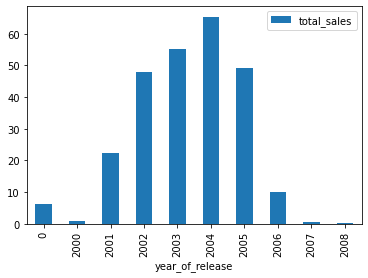

XOne


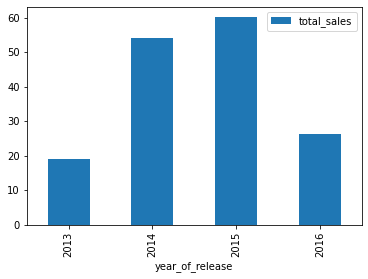

In [43]:
for platform in data_pivot.index:
    print(platform)
    (data
     .query('platform == @platform')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar')
    )
    plt.show()

### Вывод
По построенным график мы видим, что, в среднем, платформы пользуются спросом в течение 5-ти лет, именно в течение данного периода наблюдается рост продаж, а после начинается довольно стремительный спад и платформы перестают быть востребованными, что может быть обуслолено появлением новых более технологичных и актуальных, т.о. примерно по истечению 5ти лет платформа перестает быть конкурентоспособной на рынке. При этом видно, что средняя продолжительность жизни платформы - 10 лет

Для дальнейшего анализа нам необходимо выбрать актуальный период, на который мы могли бы основываться прогнозируя продажи на 2017 год. Учитывая среднюю продолжительность жизни платформы - 10 лет и тот факт, что платформы постоянно заменяют друг друга, поскольку появляются все более новые и технологичные, за актуальный период целесообразно взять года от 2006 до 2016. А также в данные периоды мы видим существенный рост продаж игры и затем спад, после того, как рынок стабилизровался, данные будут более полные и учитывать разные состояния рынка.

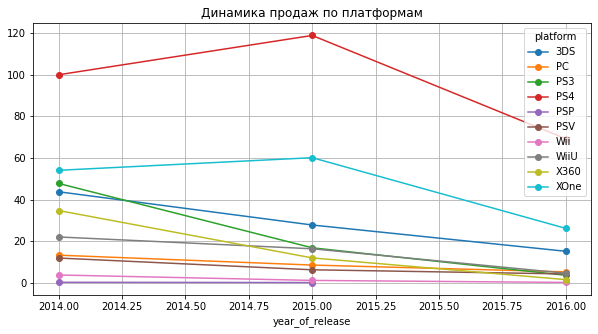

In [28]:
#отбросим предыдущие года
data_period = data.query ('year_of_release >= 2014')
data_period.pivot_table(index= 'year_of_release', columns='platform', 
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', figsize = (10, 5));
plt.title('Динамика продаж по платформам');

In [29]:
#найдем наиболее популярные платформы за этот период
data_pivot2 = data_period.pivot_table(index=['platform'], values='total_sales', aggfunc='sum')
display(data_pivot2.sort_values(by='total_sales', ascending = False).head())

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22


### Вывод
По полученным данным наиболее популярной платформой на анализируемом периоде была PS4/ Также вторая по популярности платформа XOne. Данные платформы являются усовершенствованными версиями PS3 и X360, они относительно новые, поэтому набирают свою популярность.

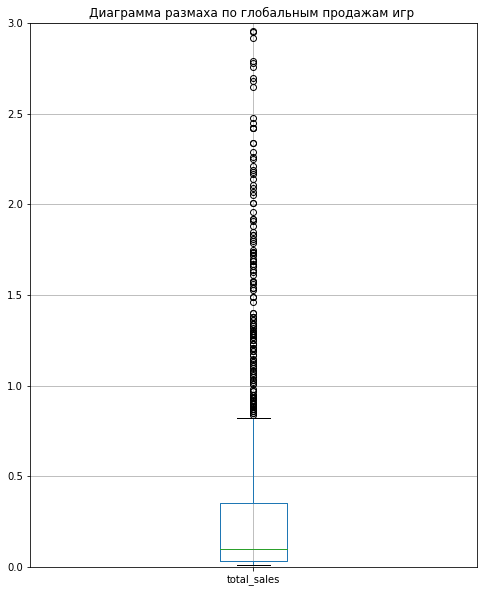

In [30]:
#построим диаграмму размаха по глобальным продажам игр
data_period.boxplot('total_sales', figsize=(8, 10)).set_ylim(0, 3)
plt.title('Диаграмма размаха по глобальным продажам игр ');

По вышеприведенной диаграмме размаха можно предположить, что средние продажи игр по платформам составялют 0,9 млн.долл., а медианной значение - 0,2 млн. долл.

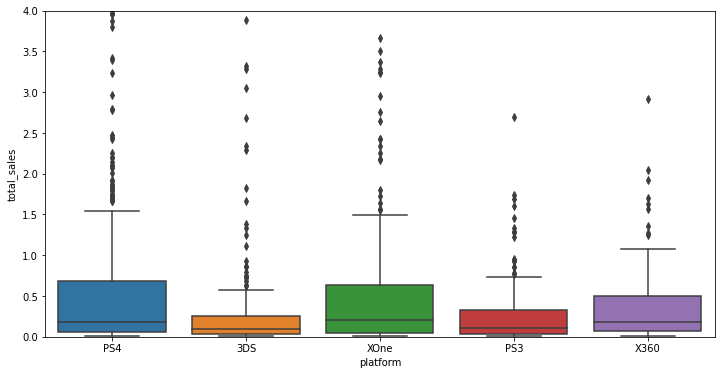

In [31]:
data_period_dg = data_period.query('(platform == "PS4") | (platform == "XOne") | (platform == "3DS") | (platform == "PS3") | (platform == "X360")')
plt.figure(figsize=(12,6))
sns.boxplot(data=data_period_dg, x='platform', y = 'total_sales')
plt.ylim(0,4);

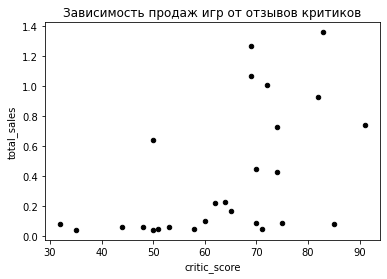

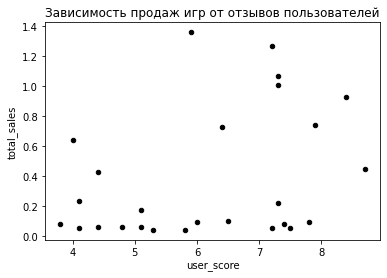

In [32]:
#для определения того, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков,
#построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами, для примера возьмем X360 (самая популярная на рассматриваемом периоде)

data_x360 = data_period[(data_period['platform'] == 'X360') & (data_period['critic_score'] > 0) & (data_period['user_score'] >= 0)]

data_x360.plot(kind='scatter', x='critic_score', y='total_sales', color='black');
plt.title('Зависимость продаж игр от отзывов критиков');
data_x360.plot(kind='scatter', x='user_score', y='total_sales', color='black');
plt.title('Зависимость продаж игр от отзывов пользователей');

### Вывод
Диаграммы размаха демонстрируют наличие взимосвязи между оценков критиков/пользователей и объемом продаж, так с увеличением рейтинга критика/пользователя увеличивается и средний объем продаж игры, что вполне логично, поскольку чем лучше игра, тем больше у нее положительных оценок, тем выше продажи.

In [33]:
data_period.corr()
#относительно других платформ можно сказать, что сильнее на продажи влияет оценка критиков

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.122977,-0.093408,-0.056134,-0.096834,0.017237,-0.033196,-0.117482
na_sales,-0.122977,1.000000,0.735920,0.264362,0.841484,0.214172,0.166442,0.913660
eu_sales,-0.093408,0.735920,1.000000,0.188675,0.930140,0.210498,0.153593,0.915583
jp_sales,-0.056134,0.264362,0.188675,1.000000,0.170780,-0.037253,-0.051643,0.418281
other_sales,-0.096834,0.841484,0.930140,0.170780,1.000000,0.202366,0.151828,0.935091
critic_score,0.017237,0.214172,0.210498,-0.037253,0.202366,1.000000,0.795549,0.203231
user_score,-0.033196,0.166442,0.153593,-0.051643,0.151828,0.795549,1.000000,0.148246
total_sales,-0.117482,0.913660,0.915583,0.418281,0.935091,0.203231,0.148246,1.000000


Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64

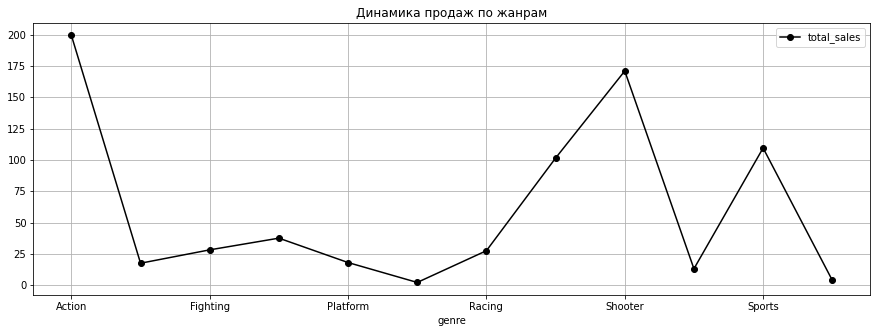

In [34]:
#проанализиурем продажи игр в разрезе жанров
data_period.pivot_table(index= 'genre',
                 values = 'total_sales', 
                 aggfunc = 'sum').plot(grid=True, style='o-', color='black', figsize = (15, 5));
plt.title('Динамика продаж по жанрам');
data_period['genre'].value_counts()

### Вывод 
По графику наблюдаем, что самыми популярными жанрами игр являются Action, Sports и Shooter, именно по ним выявлены наибольшие продажи в анализируемом периоде. При этом можно отметить жанры, которые пользуются меньшей популярностью, к примеру, Strategy, Puzzle и Platform.

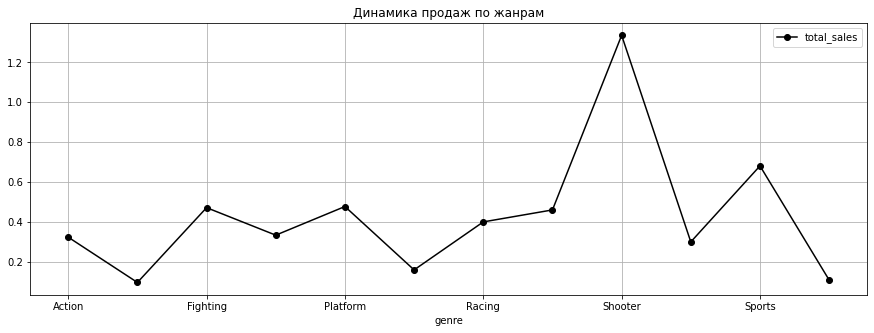

In [35]:
data_period.pivot_table(index= 'genre',
                 values = 'total_sales', 
                 aggfunc = 'mean').plot(grid=True, style='o-', color='black', figsize = (15, 5));
plt.title('Динамика продаж по жанрам');

### Шаг 4. Составление портрета пользователя каждого региона

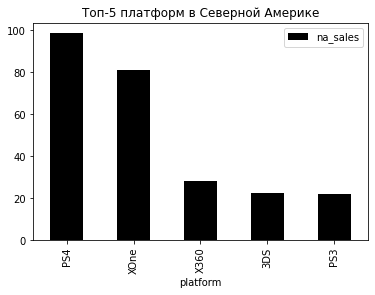

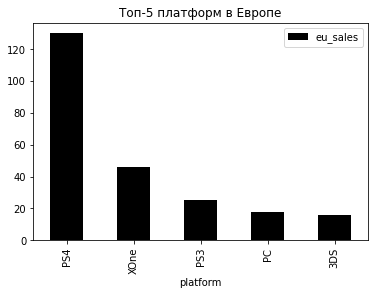

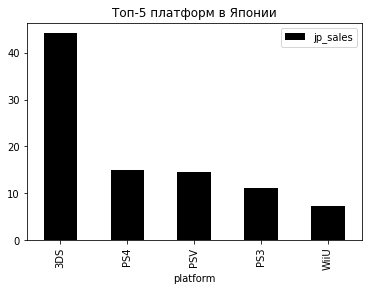

In [36]:
#найдем топ-5 платформ для каждого региона
data_period.groupby(by='platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Топ-5 платформ в Северной Америке');
data_period.groupby(by='platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Топ-5 платформ в Европе');
data_period.groupby(by='platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Топ-5 платформ в Японии');

### Вывод
По полученным графикам мы видим, что в Северной Америке наибольшей популярностью пользуется платформа X360, в Европе - PS3, а в Японии - DS. При этом Топ-5 в регионах сопоставимый.

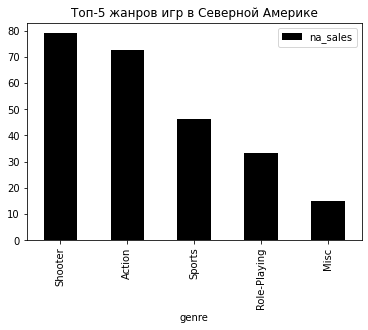

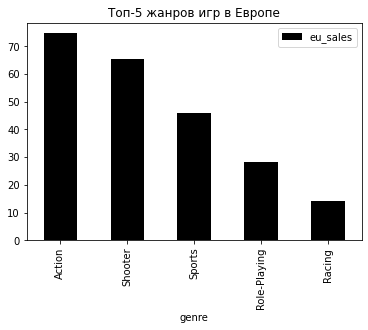

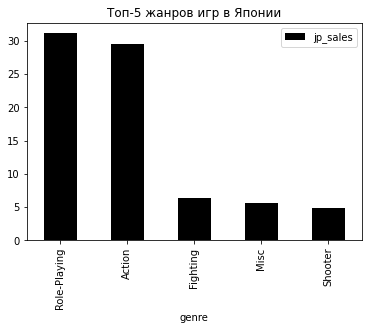

In [37]:
#найдем топ-5 жанров игр для каждого региона
data_period.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Топ-5 жанров игр в Северной Америке');
data_period.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Топ-5 жанров игр в Европе');
data_period.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Топ-5 жанров игр в Японии');

### Вывод
По полученным графикам видно, что в Северной Америке и Европе преобладет такой жанр как Action, а в Японии - Role-Playing, что может быть обусловлено существенным различием культурных особенностей регионов.

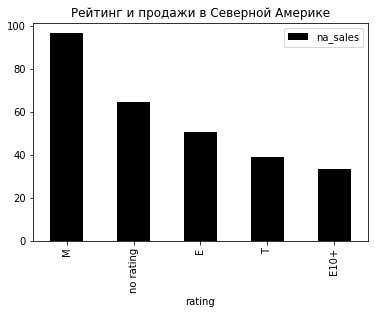

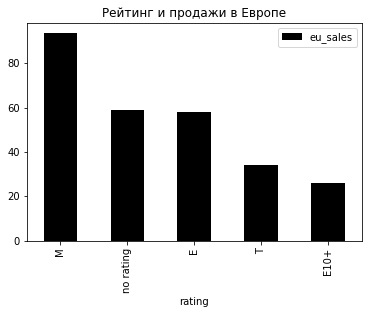

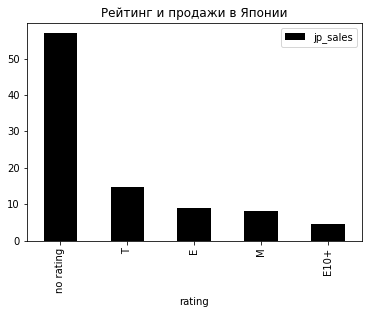

In [38]:
#найдем, есть ли зависимость между рейтингом и ESBR и продажами в регионах
data_period.groupby(by='rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Рейтинг и продажи в Северной Америке');
data_period.groupby(by='rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Рейтинг и продажи в Европе');
data_period.groupby(by='rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', 
                                                                 ascending=False).head(5).plot(kind='bar', 
                                                                                               color = 'black');
plt.title('Рейтинг и продажи в Японии');

### Вывод
Игры с рейтинг Е - "для всех" продаются больше, что логично, т.к. они не имеют возрастных ограничений, следовательно, имеют широкую целевую аудиторию. Меньше всего продаются игры с рейтингом Е10+ - "для всех от 10 лет и старше".

### Шаг 5. Проверяем гипотезы

1) Гипотезы:

H0: средний пользовательский рейтинг платформ Xbox One и PC одинаковый

H1: средний пользовательский рейтинг платформ Xbox One и PC различается

Проверим гипотезы с использованием t-теста

In [39]:
sample_1 = data_period[(data_period['platform'] == 'XOne') & (data_period['user_score'] > 0)]['user_score']
sample_2 = data_period[(data_period['platform'] == 'PC') & (data_period['user_score'] > 0)]['user_score']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


2) Гипотезы

H0: средние пользовательские рейтинги жанров Action и Sports различается

H1: средние пользовательские рейтинг жанров Action и Sports одинаковый

Проверим гипотезы с использованием t-теста

In [40]:
sample_3 = data_period[(data_period['genre'] == 'Action') & (data_period['user_score'] > 0)]['user_score']
sample_4 = data_period[(data_period['genre'] == 'Sports') & (data_period['user_score'] > 0)]['user_score']

alpha = .05

results = st.ttest_ind(
    sample_3, 
    sample_4)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


### Шаг 6. Общий вывод
По итогам проведенного анализа можно сделать следующие выводы:

1) Наибольшее влияние на продажи игр оказывают оценки критиков;

2) Самыми популярными жанрами игр являются Action, Sports и Shooter, именно по ним выявлены наибольшие продажи в анализируемом периоде, меньшей популярностью пользуются Strategy, Puzzle и Platform;

3) В Северной Америке наибольшей популярностью пользуется платформа X360, в Европе - PS3, а в Японии - DS, в части жанров - в Северной Америке и Европе преобладет такой жанр как Action, а в Японии - Role-Playing;

4) Наибольшие продажи выявлены по играм с присвоенным рейтингом E - "для всех".

